In [10]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt


In [11]:
all_frames = md.load_xtc("../simulation/npt.xtc", top="../simulation/box.gro")


In [12]:
all_frames_data = []

for i in range(all_frames.xyz.shape[0]):
    mol_com_pos = []

    for res in all_frames.top.residues:
        # print(res.index,end=" ")
        pos = []
        for atom in res.atoms:
            # print(atom.index,"-->" , frame.xyz[0][atom.index],end=" ")
            pos.append(all_frames.xyz[i][atom.index])
        mol_com_pos.append(np.mean(pos,axis=0))
        
        # print()
    mol_com_pos = np.array(mol_com_pos)    
    all_frames_data.append(mol_com_pos)

all_frames_data = np.array(all_frames_data)
print(all_frames_data.shape)

(51, 101, 3)


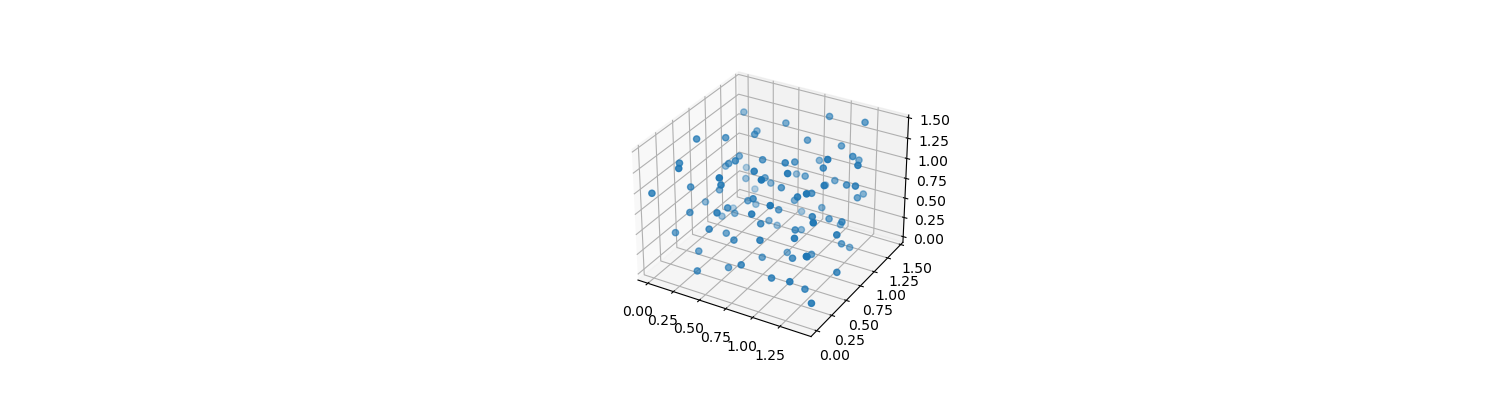

In [17]:
%matplotlib widget

frame = 10

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(all_frames_data[frame][:,0],all_frames_data[frame][:,1],all_frames_data[frame][:,2])
plt.show()

In [5]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [20]:
cutoff = 0.5

all_edge_list = []
for frame_i in range(all_frames_data.shape[0]):
    from_list = []
    to_list = []

    for i in range(len(all_frames_data[frame_i])):
        for j in range(i+1,len(all_frames_data[frame_i])):
            if np.linalg.norm(all_frames_data[frame_i][i]-all_frames_data[frame_i][j]) < cutoff:
                # print(i,j,np.linalg.norm(mol_com_pos[i]-mol_com_pos[j]))
                from_list.append(i)
                to_list.append(j)

                to_list.append(i)
                from_list.append(j)

    edge_list = np.array([from_list,to_list])
    all_edge_list.append(edge_list)

print(len(all_edge_list))

51


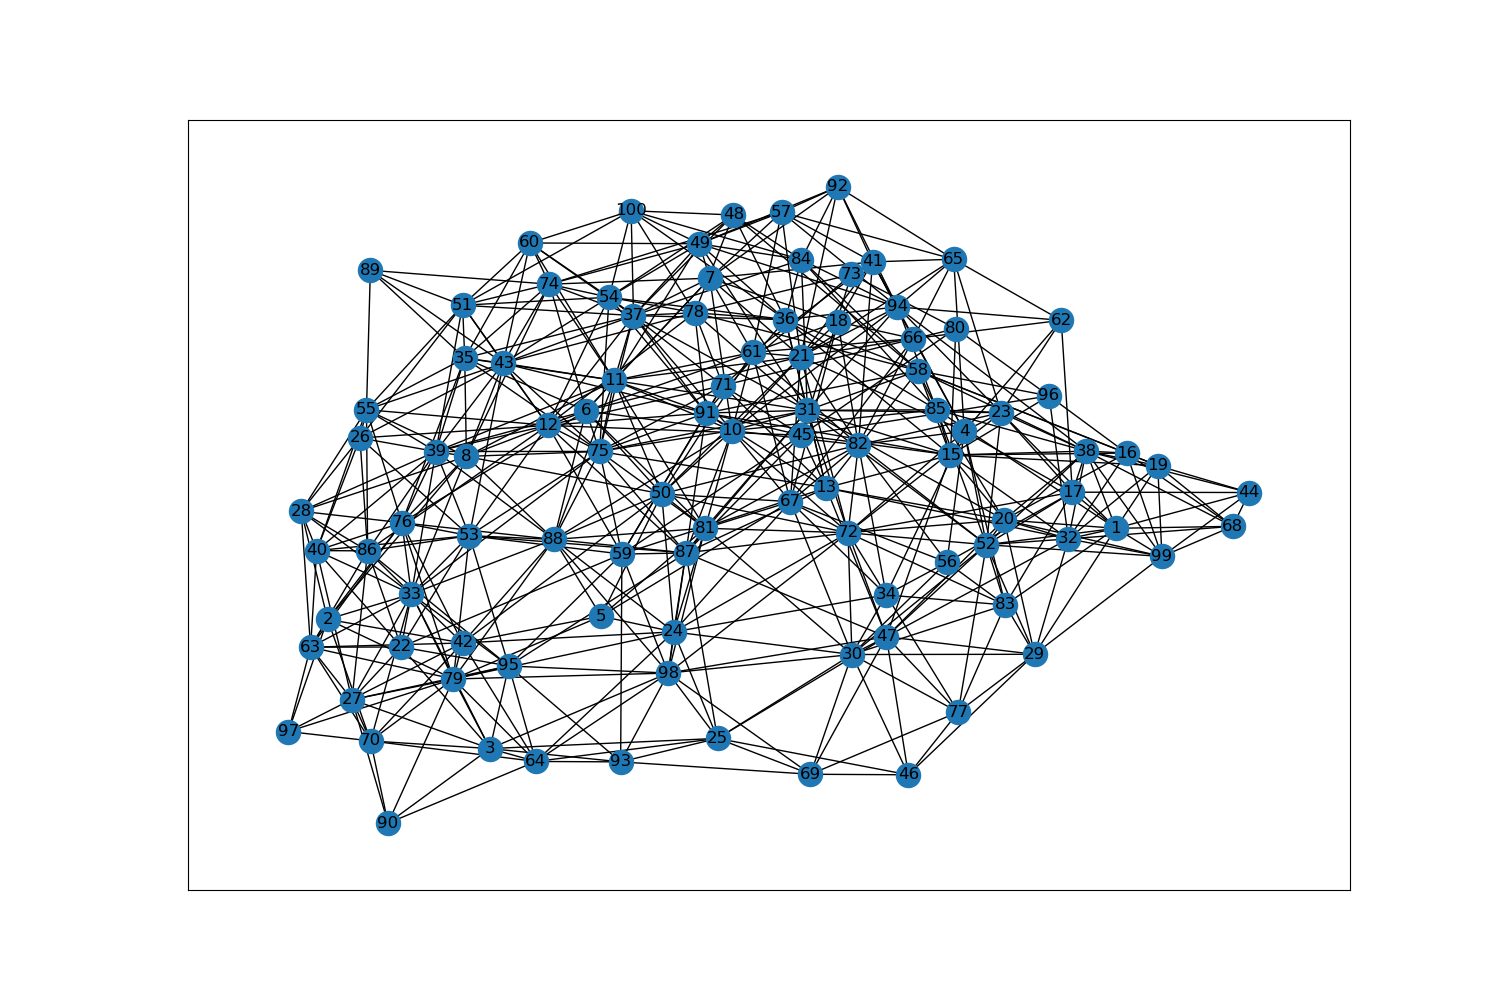

In [7]:
%matplotlib widget

frame = 10

plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=101)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)
